In [13]:
!pip install scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [15]:
csv_url = r"C:\Users\GIA BAO\OneDrive - Trường ĐH CNTT - University of Information Technology\FPT - Sheet1.csv"

In [16]:
data = pd.read_csv(csv_url, delimiter=';')

In [17]:
print(data)

            Date     Closed       Open        High        Low    Vol  Change
0     30/12/2016  15,852.00  15,707.90   15,942.10  15,617.80  3.79M   1.27%
1     03/01/2017  16,158.20  15,960.10   16,194.30  15,960.10  2.34M   1.93%
2     04/01/2017  16,302.30  16,140.20   16,464.50  16,104.20  2.36M   0.89%
3     05/01/2017  16,248.30  16,284.30   16,356.40  16,248.30  1.42M  -0.33%
4     06/01/2017  16,194.30  16,284.30   16,392.40  16,194.30  1.85M  -0.33%
...          ...        ...        ...         ...        ...    ...     ...
1736  13/12/2023  95,200.00  97,400.00   97,400.00  95,200.00  2.15M  -1.65%
1737  14/12/2023  96,200.00  95,800.00   96,400.00  95,200.00  1.71M   1.05%
1738  15/12/2023  96,200.00  96,200.00   96,300.00  95,000.00  1.47M   0.00%
1739  18/12/2023  94,000.00  95,900.00   96,200.00  93,700.00  2.27M  -2.29%
1740  19/12/2023  94,600.00  99,500.00  100,500.00  93,500.00  1.25M   0.64%

[1741 rows x 7 columns]


In [18]:
# Convert the 'Date' column to datetime with the correct format
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
# Set the 'Date' column as the index
data.set_index('Date', inplace=True)

In [19]:
# Remove ',' and convert format
cols_to_convert = ['Closed', 'Open', 'High', 'Low']
data[cols_to_convert] = data[cols_to_convert].replace(',', '', regex=True).astype(float)

# Convert the format of the "Vol" column
def convert_vol(value):
    if 'M' in value:
        return float(value.replace('M', '')) * 1e6
    elif 'K' in value:
        return float(value.replace('K', '')) * 1e3
    else:
        return float(value)

data['Vol'] = data['Vol'].apply(convert_vol)

# Convert the format of the "Change" column
data['Change'] = data['Change'].replace('%', '', regex=True).astype(float) / 100.0


In [20]:
print(data)

             Closed     Open      High      Low        Vol  Change
Date                                                              
2016-12-30  15852.0  15707.9   15942.1  15617.8  3790000.0  0.0127
2017-01-03  16158.2  15960.1   16194.3  15960.1  2340000.0  0.0193
2017-01-04  16302.3  16140.2   16464.5  16104.2  2360000.0  0.0089
2017-01-05  16248.3  16284.3   16356.4  16248.3  1420000.0 -0.0033
2017-01-06  16194.3  16284.3   16392.4  16194.3  1850000.0 -0.0033
...             ...      ...       ...      ...        ...     ...
2023-12-13  95200.0  97400.0   97400.0  95200.0  2150000.0 -0.0165
2023-12-14  96200.0  95800.0   96400.0  95200.0  1710000.0  0.0105
2023-12-15  96200.0  96200.0   96300.0  95000.0  1470000.0  0.0000
2023-12-18  94000.0  95900.0   96200.0  93700.0  2270000.0 -0.0229
2023-12-19  94600.0  99500.0  100500.0  93500.0  1250000.0  0.0064

[1741 rows x 6 columns]


In [21]:
# MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [22]:
# Split the data into Train-Val-Test sets with different ratios
# Ratio: 7:2:1
train_size_1 = int(0.7 * len(data))
test_size_1 = int(0.2 * len(data))
val_size_1 = len(data) - train_size_1 - test_size_1

train_1 = data[:train_size_1]
test_1 = data[train_size_1:train_size_1+test_size_1]
val_1 = data[train_size_1+test_size_1:]

#Ratio: 6:3:1
train_size_2 = int(0.6 * len(data))
test_size_2 = int(0.3 * len(data))
val_size_2 = len(data) - train_size_2 - test_size_2

train_2 = data[:train_size_2]
test_2 = data[train_size_2:train_size_2+test_size_2]
val_2 = data[train_size_2+test_size_2:]

#Ratio 5:3:2
train_size_3 = int(0.5 * len(data))
test_size_3 = int(0.3 * len(data))
val_size_3 = len(data) - train_size_3 - test_size_3

train_3 = data[:train_size_3]
test_3 = data[train_size_3:train_size_3+test_size_3]
val_3 = data[train_size_3+test_size_3:]

In [25]:
# Function to calculate RMSE, MAE, MAPE
def evaluate_model(train, test, val):
    exog_vars = ['Open', 'High', 'Low', 'Vol', 'Change']
    order = (1, 1, 1)

    # Build and train ARIMAX model on the training set
    model = SARIMAX(train['Closed'], exog=train[exog_vars], order=order)
    results = model.fit(disp=False)

     # Predict on the validation and test set
    pred_test = results.get_forecast(steps=len(test), exog=test[exog_vars])
    pred_val = results.get_forecast(steps=len(val), exog=val[exog_vars])

     # Predict the next 30 days
    last_data = val.index[-1] + pd.DateOffset(1)
    next_30_days_index = pd.date_range(last_data, periods=30)
    pred_next_30_days = results.get_forecast(steps=30, exog=val[-30:][exog_vars])

    # Calculate evaluation metrics
    rmse_test = mean_squared_error(test['Closed'], pred_test.predicted_mean, squared=False)
    mae_test = mean_absolute_error(test['Closed'], pred_test.predicted_mean)
    mape_test = mean_absolute_percentage_error(test['Closed'], pred_test.predicted_mean)

    rmse_val = mean_squared_error(val['Closed'], pred_val.predicted_mean, squared=False)
    mae_val = mean_absolute_error(val['Closed'], pred_val.predicted_mean)
    mape_val = mean_absolute_percentage_error(val['Closed'], pred_val.predicted_mean)

    return (
        rmse_test, mae_test, mape_test,
        rmse_val, mae_val, mape_val,
        pred_test.predicted_mean, pred_val.predicted_mean, pred_next_30_days.predicted_mean
    )

In [26]:
# Evaluate the model with a ratio of 7:2:1
rmse_test_1, mae_test_1, mape_test_1, rmse_val_1, mae_val_1, mape_val_1, y_pred_test_1, y_pred_val_1, y_next_30_days_1 = evaluate_model(train_1, test_1, val_1)

# Evaluate the model with a ratio of 6:3:1
rmse_test_2, mae_test_2, mape_test_2, rmse_val_2, mae_val_2, mape_val_2, y_pred_test_2, y_pred_val_2, y_next_30_days_2 = evaluate_model(train_2, test_2, val_2)

# Evaluate the model with a ratio of 5:3:2
rmse_test_3, mae_test_3, mape_test_3, rmse_val_3, mae_val_3, mape_val_3, y_pred_test_3, y_pred_val_3, y_next_30_days_3 = evaluate_model(train_3, test_3, val_3)

C:\Users\GIA BAO\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\GIA BAO\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\GIA BAO\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\GIA BAO\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available.

In [27]:
# Print result
print("Ratio 7:2:1")
print(f"RMSE Test: {rmse_test_1:.2f}, MAE Test: {mae_test_1:.2f}, MAPE Test: {mape_test_1:.2f}")
print(f"RMSE Validation: {rmse_val_1:.2f}, MAE Validation: {mae_val_1:.2f}, MAPE Validation: {mape_val_1:.2f}\n")

print("Ratio 6:3:1")
print(f"RMSE Test: {rmse_test_2:.2f}, MAE Test: {mae_test_2:.2f}, MAPE Test: {mape_test_2:.2f}")
print(f"RMSE Validation: {rmse_val_2:.2f}, MAE Validation: {mae_val_2:.2f}, MAPE Validation: {mape_val_2:.2f}\n")

print("Ratio 5:3:2")
print(f"RMSE Test: {rmse_test_3:.2f}, MAE Test: {mae_test_3:.2f}, MAPE Test: {mape_test_3:.2f}")
print(f"RMSE Validation: {rmse_val_3:.2f}, MAE Validation: {mae_val_3:.2f}, MAPE Validation: {mape_val_3:.2f}")

Ratio 7:2:1
RMSE Test: 1461.31, MAE Test: 1125.04, MAPE Test: 1.39
RMSE Validation: 2518.10, MAE Validation: 2033.78, MAPE Validation: 2.23

Ratio 6:3:1
RMSE Test: 6808.51, MAE Test: 6407.98, MAPE Test: 8.06
RMSE Validation: 9361.68, MAE Validation: 9181.89, MAPE Validation: 10.42

Ratio 5:3:2
RMSE Test: 11493.31, MAE Test: 9802.75, MAPE Test: 13.47
RMSE Validation: 16031.43, MAE Validation: 15884.43, MAPE Validation: 18.99


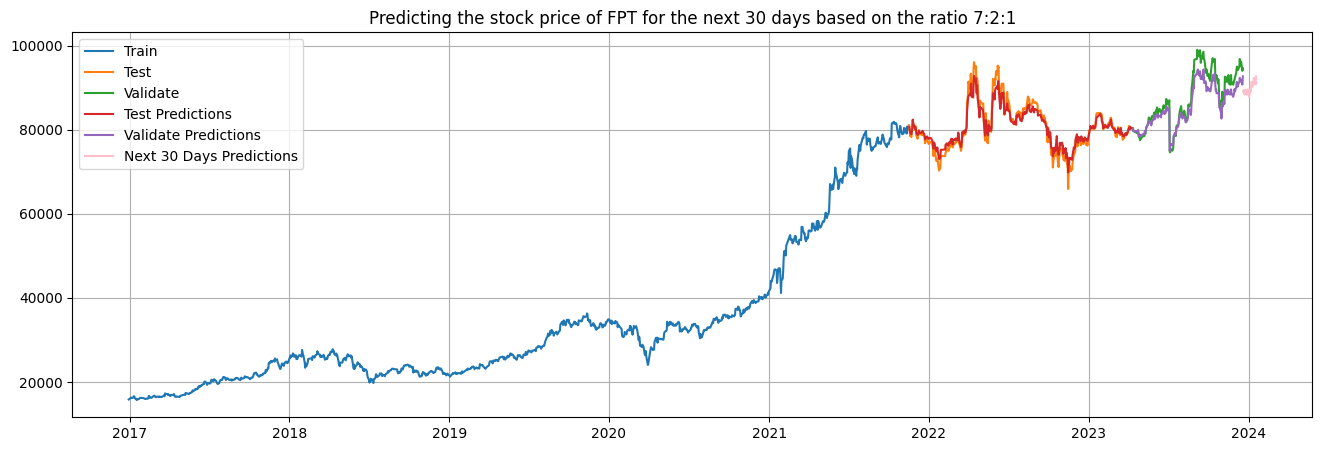

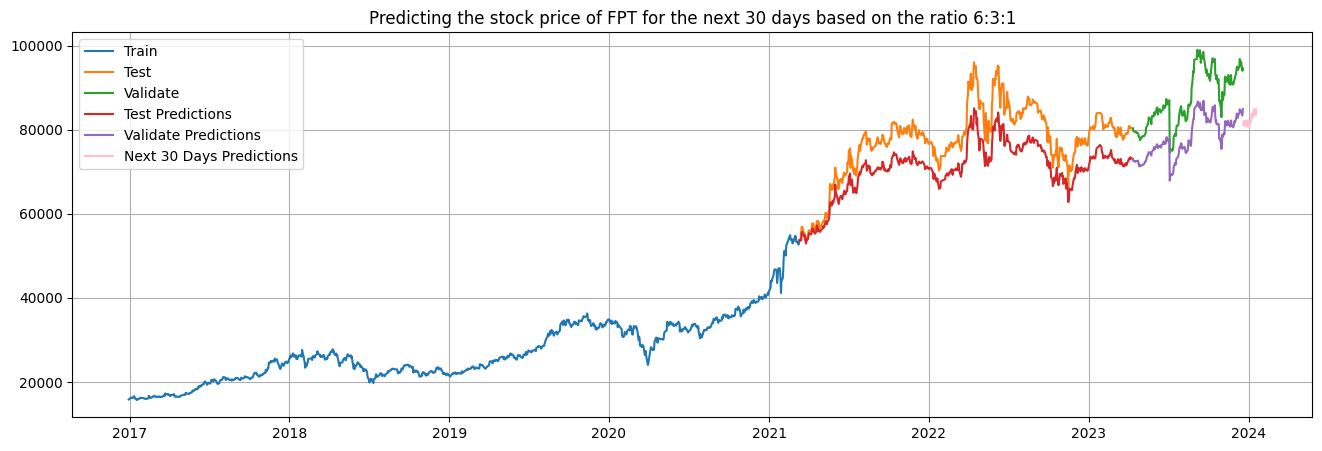

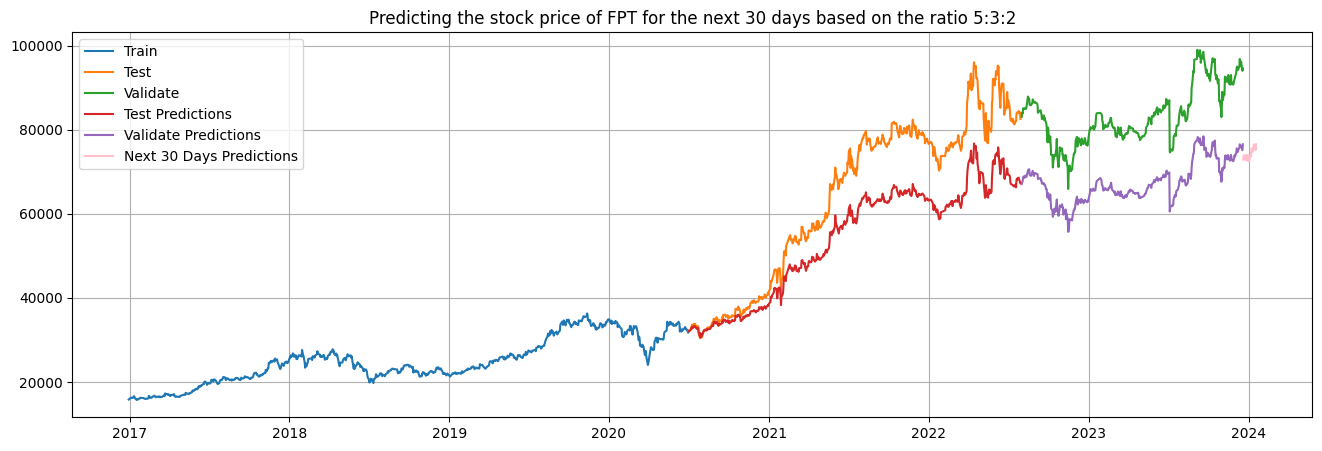

In [29]:
import matplotlib.pyplot as plt

# Plotting function for multiple ratios
def plot_all_predictions(train, test, val, y_pred_test, y_pred_val, y_next_30_days, ratio_label):
    plt.figure(figsize=(16, 5))
    plt.title(f"Predicting the stock price of FPT for the next 30 days based on the ratio {ratio_label}")
    plt.grid(True)
    
    # Plotting training, testing, and validation data
    plt.plot(train.index, train['Closed'], label='Train')
    plt.plot(test.index, test['Closed'], label='Test')
    plt.plot(val.index, val['Closed'], label='Validate')

    # Plotting predictions for test and validation sets
    plt.plot(test.index[:len(y_pred_test)], y_pred_test, label='Test Predictions')
    plt.plot(val.index[:len(y_pred_val)], y_pred_val, label='Validate Predictions')

    # Plotting predictions for the next 30 days
    last_data = val.index[-1] + pd.DateOffset(1)  # Date for the first day of the next 30 days
    next_30_days_index = pd.date_range(last_data, periods=30)
    plt.plot(next_30_days_index, y_next_30_days, color="pink", label='Next 30 Days Predictions')

    plt.legend()
    plt.show()

# Plotting for all three ratios
plot_all_predictions(train_1, test_1, val_1, y_pred_test_1, y_pred_val_1, y_next_30_days_1, "7:2:1")
plot_all_predictions(train_2, test_2, val_2, y_pred_test_2, y_pred_val_2, y_next_30_days_2, "6:3:1")
plot_all_predictions(train_3, test_3, val_3, y_pred_test_3, y_pred_val_3, y_next_30_days_3, "5:3:2")